In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp, quad


# Astrophysical Constants

class Constants:
    q = 4.8e-10
    c = 3e10
    hbar = 1.05e-27
    E_s = 4.4e13
    G = 6.67e-8
    alpha = 1 / 137
    M = 3e33
    R_ns = 1.2e6
    sigma = 6.65e-25
    R_c = 1e7
    m_e = 9.1e-28
    D = 3e26
    delta_nu = 1e8
    efficiency = 1e-2
    B_s = 1e12
    nu = 1e9
    rho = 1e6
    dnu = 1e9
    B_c = 4.4e13
    
def b_single(t, a0, r, theta, phi, B_s, theta_m):

    # Find the magnetic field at a point r, theta, phi, t
    
    a = a_t(t, a0) # separation
    beta = beta_t(a) # magnetar linear velocity
    phi_m = phi_m_t(beta, t, a) # magnetar phi coordinate

    # Convert to x,y,z
    x1 = Constants.R_ns * r * np.sin(theta) * np.cos(phi)
    x2 = Constants.R_ns * (a / Constants.R_ns) * np.sin(theta_m) * np.cos(phi_m)
    y1 = Constants.R_ns * r * np.sin(theta) * np.sin(phi)
    y2 = Constants.R_ns * (a / Constants.R_ns) * np.sin(theta_m) * np.sin(phi_m)
    z1 = Constants.R_ns * r * np.cos(theta)
    z2 = Constants.R_ns * (a / Constants.R_ns) * np.cos(theta_m)

    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
    hypo = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2) # Distance from point r,theta,phi to magnetar centre

    if hasattr(hypo, '__len__'):
        mask1 = Constants.R_ns > hypo
        mask2 = r < 1.0
        mask3 = np.invert(mask1 | mask2)

        b = np.zeros(len(hypo))
        b[mask1] = 0
        b[mask2] = 0
        b[mask3] = B_s * (Constants.R_ns ** 3) / (hypo[mask3] ** 3) # magnetic field strength

    else:

        if Constants.R_ns > hypo:
            b = 0
        elif r < 1.0:
            b = 0
        else:
            b = B_s * (Constants.R_ns ** 3) / (hypo ** 3) # magnetic field strength

    return b


def beta_t(a):
    # Velocity of neutron star
    
    return np.sqrt(2 * Constants.G * Constants.M / a) / Constants.c


def phi_m_t(beta, t, a):
    # Phi coordinate of magnetar
    return (beta * Constants.c) * (t / a) % (2. * np.pi)
    # return 2 * np.pi / 3
    
def f_single(t, a0, r, theta, phi, B_s, theta_m):
    # Function to find the electric field E1 due to conductor motion at time t

    if r <= 1.0:
        return 0

    a = a_t(t, a0)
    beta = beta_t(a)
    b_val = b_single(t, a0, r, theta, phi, B_s, theta_m)
    phi_m = phi_m_t(beta, t, a)

    # Eq. from Lyutikov
#     numerator = -3 * np.sin(theta) * np.cos(theta) * (6 - r ** (-3)) * np.cos(phi) * b_val * beta * r ** (-3)
#     denominator = 2 * np.sqrt(2) * np.sqrt(8 * (1 - r **
#                                                 (-3)) ** 2 + 6 * (4 - r ** (-3)) * r ** (-3) * np.sin(theta) ** 2)
      # Eq. from Om 
    numerator = 3 * np.sin(theta)* np.cos(theta) * np.cos(phi - phi_m) * (1 - r ** (-3)) * b_val * beta * r ** (-3)
    denominator = np.sqrt(4 * np.cos(theta)**2 * (1 - r ** (-3))**2 + np.sin(theta)**2 * (2+ r ** (-3))**2)
    return numerator / denominator


def t_t(a):
    # Time until formal merger
    return ((5 / 512) * Constants.c ** 5 * a ** 4) / (Constants.G ** 3 * Constants.M ** 3)


def t_merge(a, a_min):
    # Time until a_min
    
    return t_t(a) - t_t(a_min)


def a_t(t, a0):
    # Separation
    
    return ((a0 ** 4) * (1 - (t / t_t(a0)))) ** (1 / 4)

def lower_limit_pulsar(beta,B,rho,a,gap,dV):
    # Analytic luminosity upper limit
    
    P = 2*np.pi*a / (beta*Constants.c)
    n = 2*B/(Constants.c* Constants.q*P)
    L_r = (1e-2 * Constants.q**2 * n**2 * h**2 * dV**(2/3) * Constants.c)/(Constants.D**2 * Constants.dnu)
    
    return L_r*1e23

def gap_lower_limit(beta,B,rho,a,previous_gap):
    # Analytic gap height lower limit
    
    P = 2*np.pi*a / (beta*Constants.c)
    n = 2*B/(Constants.c* Constants.q*P)
    k1 = 0.4 * rho**2 * Constants.m_e**4 * Constants.c**7 * Constants.B_c
    k2 = 192 * np.pi**3 * Constants.hbar * Constants.q**3 * n**3 * B
    
    
    gap = (14/(6**(6/7))) * (k1/k2)**(1/7)
    return gap




def gap(beta,B,rho,a,E_parallel,previous_gap):
    # Numerical gap height
    

    n = E_parallel/(4 * np.pi * Constants.q * previous_gap)
    
    k1 = 0.4 * rho**2 * Constants.m_e**4 * Constants.c**7 * Constants.B_c
    k2 = 192 * np.pi**3 * Constants.hbar * Constants.q**3 * n**3 *B
    
    return (7/(6**(6/7))) * (k1/k2)**(1/7)



def simple_pulsar(E_parallel, epsilon_particles, dV,D,dnu,B):
    # Numerical radio spectral luminosity
    
    h1 = (2 * 1e6**2 * Constants.m_e**4 * Constants.c**7 * Constants.B_c)
    
    h2 = (15 * 3**(3/4) *Constants.hbar * B * Constants.q**3 *E_parallel**3)
    
    h = (4/(3**(3/4))) * (h1/h2)**(1/4)
    
    voltage = E_parallel * h
    
    if (h < 1e6) and (voltage > 1e10):
        return (epsilon_particles*E_parallel**2 * Constants.c * dV**(2/3) * 1e23) / (4 * np.pi * 4 * np.pi * D**2 * dnu)
        
    else:
        return 0
    

def Coh_curv_rad_flux(E_parallel, rho, B,D,dnu):
    # Max coherent luminosity

    
    L_max_Lu = E_parallel**2 *rho**2 * Constants.c 
    L_max_Kumar = 2e40 * (B/(1e12))**2 * ((rho)/(1e6))**(2/3)
    
#     L_max_Cooper = 2e43 * (B/(1e12))**2 * P**3 *((rho)/(1e6))**(-2)

    
    return (np.min([L_max_Lu,L_max_Kumar]))*1e23/(4 * np.pi * D**2 * dnu)
    

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors


# Define Parameters
a0 = 3.5e6  # Max separation
a_min = 2.6e6  # Min separation
t_max = t_merge(a0, a_min)  # Time of merger
num_timesteps = 120

#  Linear timesteps
t_arr = np.linspace(0, t_max, num_timesteps)

# Coordinate system and empty arrays
resolution = 100
phi_arr = np.linspace(0,2*np.pi,resolution)
theta_arr = np.linspace(0,np.pi,resolution)  
r_arr = np.linspace(1, 6, resolution)

Energy_full = np.zeros((len(t_arr), len(r_arr)-1, len(theta_arr)-1, len(phi_arr)-1))
E_parallel_arr = np.zeros((len(t_arr), len(r_arr)-1, len(theta_arr)-1, len(phi_arr)-1))

Flux_arr_pulsar = np.zeros((len(t_arr), len(r_arr)-1, len(theta_arr)-1, len(phi_arr)-1))
Flux_arr_curv = np.zeros((len(t_arr), len(r_arr)-1, len(theta_arr)-1, len(phi_arr)-1))
Flux_arr_pulsar_lower_limit = np.zeros((len(t_arr), len(r_arr)-1, len(theta_arr)-1, len(phi_arr)-1))

# Either run below, or import previous run in next cell


# Total_flux_analytic = np.zeros(len(t_arr))
# for num, t in enumerate(t_arr):
#     print(num)
#     print(a_t(t, a0))
#     if num == 0:
#         h = 1e2
#     for i, r in enumerate(r_arr[:-1]):
#         for j, theta in enumerate(theta_arr[:-1]):
#             for k, phi in enumerate(phi_arr[:-1]):
                             
#                 dV = np.abs(
#                     ((r * Constants.R_ns) ** 2) * np.sin(theta) * (Constants.R_ns * (r_arr[i+1] - r_arr[i])) * (
#                             theta_arr[j+1] - theta_arr[j]) * (phi_arr[k+1] - phi_arr[k]))
    
#                 B = b_single(t, a0, r, theta, phi, Constants.B_s, np.pi/2)
#                 E_parallel = f_single(t, a0, r, theta, phi, Constants.B_s, np.pi/2)
            
                

#                 Flux_arr_pulsar[num,i,j,k] = simple_pulsar(E_parallel, 1e-2, dV,Constants.D,1e9,B)
    
#                 Flux_arr_curv[num, i, j, k] = Coh_curv_rad_flux(np.abs(E_parallel), Constants.rho,
#                                                                 B,Constants.D,1e8)
        
#                 h = gap_lower_limit(beta_t(a_t(t, a0)),B,1e6,a_t(t, a0),h)
# #                 print(h)
#                 Flux_arr_pulsar_lower_limit[num, i, j, k] = lower_limit_pulsar(beta_t(a_t(t, a0)),B,1e6,a_t(t, a0),h,dV)
    
    
# Flux_arr_pulsar_2d = Flux_arr_pulsar.reshape([num_timesteps,(resolution-1)**3])
# Flux_arr_curv_2d = Flux_arr_curv.reshape([num_timesteps,(resolution-1)**3])

    
#                 Max_flux_arr_curv[num,i,j,k] = Coh_curv_rad_flux(np.abs(E_parallel), 1e6, B,3e26,1e8,1)
#                 Energy_full[num,i,j,k] = (f_single(t, a0, r, theta, phi, Constants.B_s, np.pi/2)**2)*dV

# loaded_arr = np.loadtxt("Energy_Array_60_20.txt")

# load_original_arr = loaded_arr.reshape([num_timesteps,resolution,resolution,resolution])

# Energy_full = load_original_arr

# E_parallel_arr = np.zeros((len(t_arr), len(r_arr), len(theta_arr), len(phi_arr)))
# Flux_arr = np.zeros((len(t_arr), len(r_arr), len(theta_arr), len(phi_arr)))
# for num,t in enumerate(t_arr):
#     for i, r in enumerate(r_arr):
#         for j, theta in enumerate(theta_arr):
#             for k, phi in enumerate(phi_arr):

#                 dV = np.abs(((r * Constants.R_ns) ** 2) * np.sin(phi) * (Constants.R_ns * (r_arr[i] - r_arr[i - 1])) * (
#                                 theta_arr[j] - theta_arr[j - 1]) * (phi_arr[k] - phi_arr[k - 1]))
                
#                 E_parallel_arr[num,i,j,k] = (Energy_full[num,i,j,k]/dV)**(1/2)
                

#                 Flux_arr[num,i,j,k] =  Pulsar_flux(E_parallel_arr[num,i,j,k], 1e-4, 1e11, 1e6, 1e12, dV,3e26,1e8)
                
                

# Energy_sum = np.sum(Energy_full, axis=(1, 2, 3)) # Total energy in the E-field
# # print(Energy_sum[-5:-1])

# Flux_arr = Energy_Flux(Energy_sum, Constants.efficiency,1e6,Constants.delta_nu,Constants.D)

# Pulsar_lower_limit = np.sum(np.nan_to_num(Flux_arr_pulsar_lower_limit), axis=(1, 2, 3))
# np.save('numerical_pulsar_flux_lowerlimit.npy',Pulsar_lower_limit)


# Pulsar_flux_sum = np.sum(np.nan_to_num(Flux_arr_pulsar), axis=(1, 2, 3))
# np.save('numerical_pulsar_flux.npy',Pulsar_flux_sum)


# Curv_flux_max = np.max(np.nan_to_num(Max_flux_arr_curv), axis=(1, 2, 3))

In [2]:
# If loading fluxes, import here:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

loaded_arr = np.loadtxt("Flux_Array_Pulsar_100_120.npy")
load_original_arr = loaded_arr.reshape([num_timesteps,resolution-1,resolution-1,resolution-1])
Flux_arr_pulsar = load_original_arr
Pulsar_flux_sum = np.sum(np.nan_to_num(Flux_arr_pulsar), axis=(1, 2, 3))

loaded_arr = np.loadtxt("Flux_Array_Curv_100_120.npy")
load_original_arr = loaded_arr.reshape([num_timesteps,resolution-1,resolution-1,resolution-1])
Flux_arr_curv = load_original_arr

print(Pulsar_flux_sum)

NameError: name 'num_timesteps' is not defined

In [ ]:
# Simple plot for sanity check

Pulsar_flux_sum = np.sum(np.nan_to_num(Flux_arr_pulsar), axis=(1, 2, 3))

t_arr_ms = np.multiply(t_arr, 1000)
t_arr_reverse_ms = np.flip(t_arr_ms)

fig, ax = plt.subplots(figsize=[12, 8])
ax.set_yscale('log')
ax.set_ylim(1e-30, 1e5)
ax.set_xlim(t_arr_reverse_ms[0], 0)
ax.plot(t_arr_reverse_ms, Pulsar_flux_sum,color='r')
# ax.plot(t_arr_reverse_ms, Pulsar_lower_limit,color='b')
# ax.plot(t_arr_reverse_ms, Curv_flux_max,color='b')
ax.set_xlabel('Time [ms]', fontsize=22)
ax.set_ylabel(r'Total Lum', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.tick_params(direction='out', length=4, width=1, colors='k', which='both')
# ax.legend(loc=2, fontsize=16)
plt.show()

# np.save('numerical_pulsar_flux.npy',Pulsar_flux_sum)
np.save('numerical_pulsar_flux.npy',Pulsar_flux_sum)


In [ ]:
# Make subplots for specific observer lightcurves

observers_theta = [15,30,45,90] # Only loop over the first 90 deg of observers as we expect same results for other quadrants
observers_theta = [element *(np.pi/180) for element in observers_theta] # convert to radians for ease

observers_phi = [30,60,90,120,150] # Only loop over the first 180 deg of observers as we expect same results for other quadrants
observers_phi = [element *(np.pi/180) for element in observers_phi] # convert to radians for ease


unit_vector_dV = np.zeros((len(r_arr)-1, len(theta_arr)-1, len(phi_arr)-1,2)) # array to store magnetic field unit vectors for each point around conductor
Flux_aligned = np.zeros((len(t_arr),len(observers_theta),len(observers_phi))) # array to store flux values of different observers
Peak_flux_per_bin = np.zeros((len(observers_theta),len(observers_phi))) # array to store peak flux values of different observers
Flux_curv_aligned = np.zeros((len(t_arr),len(observers_theta),len(observers_phi)))

# first loop over all cells surrounding conductor
for i, r in enumerate(r_arr[:-1]):
#     print(i)
    for j, theta in enumerate(theta_arr[:-1]):
        for k, phi in enumerate(phi_arr[:-1]):
            
            # Find and store magnetic field vector at each point around conductor
            unit_vector_dV0 = np.arctan2(np.sin(theta) * (1+0.5*r**(-3)), - np.cos(theta) * (1-r**(-3))) + theta #0.5*(2 + r**(-3))*np.sin(theta) 
            if unit_vector_dV0 < 0:
                unit_vector_dV0 += 2*np.pi
            if unit_vector_dV0 > np.pi and unit_vector_dV0 < 2.*np.pi:
                unit_vector_dV[i,j,k,0] = 2.*np.pi - unit_vector_dV0
                unit_vector_dV[i,j,k,1] = ( phi + np.pi ) % (2.*np.pi)
            else:
                unit_vector_dV[i,j,k,0] = unit_vector_dV0
                unit_vector_dV[i,j,k,1] = phi
            
            
            # Next loop over all observers
            for j1, theta_obs in enumerate(observers_theta):
                for k1, phi_obs in enumerate(observers_phi):
                    if observers_theta[j1-1] % (np.pi/2.)  < unit_vector_dV[i,j,k,0]  <= observers_theta[j1]:
                        if observers_phi[k1-1] % (150/180*np.pi) < unit_vector_dV[i,j,k,1] <= observers_phi[k1]:
                            for num, t in enumerate(t_arr):
                                Flux_aligned[num,j1,k1] += Flux_arr_pulsar[num,i,j,k]
                             
                                
                    elif observers_theta[j1-1] % (np.pi/2.) < (np.pi - unit_vector_dV[i,j,k,0])  <= observers_theta[j1]:
                        if observers_phi[k1-1] % (150/180.*np.pi) < (unit_vector_dV[i,j,k,1] + np.pi) % (2.*np.pi) <= observers_phi[k1]:
                            for num, t in enumerate(t_arr):
                                Flux_aligned[num,j1,k1] += Flux_arr_pulsar[num,i,j,k]

            

# Compute peak flux over the last milliseconds
for j, theta in enumerate(observers_theta):
    for k, phi in enumerate(observers_phi):
        Peak_flux_per_bin[j,k] = np.amax(Flux_aligned[:,j,k]) # Find the peak flux for each cell
            
    


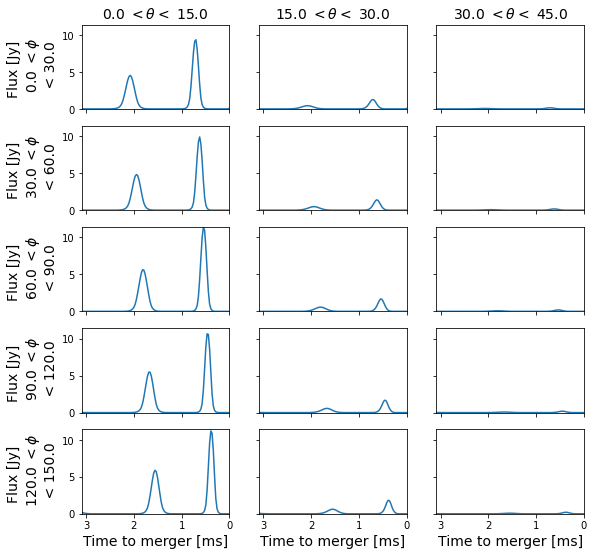

In [7]:
fig, axs = plt.subplots(figsize = [9,9],nrows=len(observers_phi), ncols=len(observers_theta)-1, 
                        sharex=True, sharey=True, squeeze=True, subplot_kw=None, gridspec_kw=None)
# Setting the values for all axes.
plt.setp(axs, xlim=(t_arr_reverse_ms[0], 0), ylim=(0,np.amax(Flux_aligned)))

for j1, theta_obs in enumerate(observers_theta):
    for k1, phi_obs in enumerate(observers_phi):
        if j1 < 3:
            axs[k1,j1].plot(t_arr_reverse_ms,Flux_aligned[:,j1,k1])
            ax.tick_params(axis='both', which='major', labelsize=18)
            ax.tick_params(axis='both', which='minor', labelsize=18)
            ax.tick_params(direction='out', length=4, width=2, colors='k', which='both')

  
            axs[k1,0].set_ylabel('Flux [Jy] \n {} $< \phi$ \n < {}'.format(np.round(observers_phi[k1-1]*180/np.pi % 150,1),np.round(observers_phi[k1]*180/np.pi,1)),fontsize=14)
            axs[0,j1].set_title(r'{} $< \theta < $ {}'.format(np.round(observers_theta[j1-1]*180/np.pi % 90),np.round(observers_theta[j1]*180/np.pi)),fontsize=14)
            axs[-1,j1].set_xlabel(r'Time to merger [ms]',fontsize=14)
        
# plt.show()
plt.savefig('plots_viewing_angles_0-30_2.png',dpi=400)

# print(Flux_aligned[:,0,0])

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.34035917e-05 3.55308664e-04 1.37136253e-03 3.65228965e-03
 8.05629350e-03 1.59157455e-02 2.92471663e-02 5.10386726e-02
 8.61479935e-02 1.42559854e-01 2.33572903e-01 3.81965348e-01
 6.28812886e-01 1.04627250e+00 1.64343491e+00 2.36345508e+00
 3.14379574e+00 3.85326168e+00 4.35259528e+00 4.53192529e+00
 4.34962520e+00 3.83383406e+00 3.09570593e+00 2.31115312e+00
 1.55489115e+00 9.45971648e-01 5.56948389e-01 3.29591805e-01
 1.93792012e-01 1.12075516e-01 6.29522843e-02 3.36947149e-02
 1.66930996e-02 7.36570871e-03 2.66738267e-03 6.43232545e-04
 4.58829340e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: The following kwargs were not used by contour: 'linestyle', 'label', 'fontsize'
/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: The following kwargs were not used by contour: 'linestyle', 'label', 'fontsize'
/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: The following kwargs were not used by contour: 'linestyle', 'label', 'fontsize'


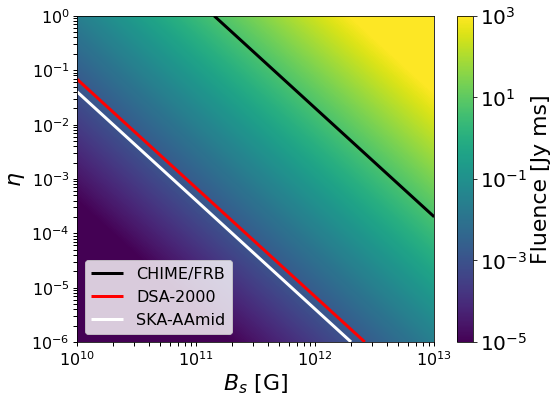

In [8]:
# Fluence as a function of B and eta 

print(Flux_aligned[:,0,0])
print(np.nan_to_num(Flux_aligned[:,0,0]))
B_arr = np.logspace(10,13,1000)
eta_arr = np.logspace(-6,0,1000)

Fluence_arr = np.zeros((len(B_arr),len(eta_arr)))

for i,B in enumerate(B_arr):
    for j,eta in enumerate(eta_arr):
        total_fluence = np.sum(Flux_aligned[:,0,0])*t_max*1000/num_timesteps # Fluence in Jansky milliseconds
        Fluence_arr[i,j] = total_fluence * (B/1e12)**2 * (eta/1e-2)
        
        
single_fluence = np.sum(Flux_aligned[:,0,0])*t_max*1000/num_timesteps

fig, ax = plt.subplots(figsize=[8, 6])

plt.pcolormesh(B_arr,eta_arr,Fluence_arr.T,norm=colors.LogNorm(vmin=0.00001, vmax=1000))#,shading='gouraud')#,extent=(min(n_e_arr),max(n_e_arr),min(rho_arr),max(rho_arr)))
plt.ylabel(r'$\eta$', fontsize=22)
plt.xlabel(r'$B_s$ [G]', fontsize=22)


cb = plt.colorbar()
cb.set_label(label=r'Fluence [Jy ms]',fontsize=22)
cb.ax.tick_params(labelsize=20)
plt.yscale('log')
plt.xscale('log')

plsr1 = plt.contour(B_arr,eta_arr,Fluence_arr.T,levels=[5],linewidths=3, colors='k',linestyle='-',label='CHIME',fontsize=16)
plsr2 = plt.contour(B_arr,eta_arr,Fluence_arr.T,levels=[0.0017],linewidths=3, colors='red',linestyle='--',label='DSA-2000',fontsize=16)
plsr3 = plt.contour(B_arr,eta_arr,Fluence_arr.T,levels=[0.001],linewidths=3, colors='white',linestyle='-',label='SKA-mid',fontsize=16)


h1,_ = plsr1.legend_elements()
h2,_ = plsr2.legend_elements()
h3,_ = plsr3.legend_elements()

ax.legend([h1[0], h2[0], h3[0]], [r'CHIME/FRB','DSA-2000',r'SKA-AAmid'],fontsize=16,loc=3)

# ax.legend(loc=2, fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.tick_params(direction='out', length=4, width=1, colors='k', which='both')
plt.savefig('fluence_fig.png',dpi=500)



In [19]:
# Find the fluence horizon distance & rate for a telescope

FoV = 0.01 # Square deg
fluence_limit = 4000 # Jy ms


full_sky = 41253
D_arr_Mpc = np.logspace(0,4,10000)
horizon = 0

for D in D_arr_Mpc:
    if single_fluence*((1e12/1e12)**2)*(100/D)**2 > fluence_limit:
        horizon = D
    else:
        pass
    
    
print(D)
print('Fluence: ',single_fluence*((1e15/1e12)**2)*(100/D)**2)

print('Horizon = ',horizon,' Mpc')

print('Rate: ',1e3 * (horizon/1000)**3 * FoV/full_sky)

print(single_fluence * (100/300)**2 * (6e13/1e12)**2)

peak_lum = np.max(Flux_aligned[:,0,0])*1e9* 4 * np.pi * (3e26)**2 * 1e-23

print(peak_lum* (4e12/1e12)**2)

10000.0
Fluence:  249.0792206923638
Horizon =  2.4936740389336003  Mpc
Rate:  3.758923741359335e-12


In [ ]:
# Flux as a function of time for for various viewing angles

fig, ax = plt.subplots(figsize=[8, 6])
ax.set_yscale('log')
ax.set_ylim(1e-5, 2*np.amax(Flux_aligned[:,:,1]))
ax.set_xlim(t_arr_reverse_ms[0], 0)

for j, theta_obs in enumerate(observers_theta):
    ax.plot(t_arr_reverse_ms, Flux_aligned[:,j,1],label=r'{} $< \theta < $ {}'.format(np.round(observers_theta[j-1]*180/np.pi % 90),np.round(observers_theta[j]*180/np.pi)),linewidth=3)

ax.set_title(r'$\epsilon_p$ = {}, $B_s$ = {}, $D$ = {}, $\delta \nu$ = {}'.format(Constants.efficiency, Constants.B_s, Constants.D, Constants.delta_nu))
ax.set_xlabel('Time [ms]', fontsize=22)
ax.set_ylabel('Flux [Jy]', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.tick_params(direction='out', length=4, width=1, colors='k', which='both')
ax.legend(loc=2, fontsize=16)
# plt.savefig('Lightcurves_viewing_angles.png',dpi=400)
plt.show()





fig, ax = plt.subplots(figsize=[8, 6])
ax.set_yscale('log')
ax.set_ylim(1e-5, 2*np.amax(Flux_aligned[:,:,1]))
ax.set_xlim(t_arr_reverse_ms[0], 0)

for k, phi_obs in enumerate(observers_phi):
    ax.plot(t_arr_reverse_ms, Flux_aligned[:,1,k],label=r'{} $< \phi < $ {}'.format(np.round(observers_phi[k-1]*180/np.pi),np.round(observers_phi[k]*180/np.pi)),linewidth=3)

ax.set_title(r'$\epsilon_p$ = {}, $B_s$ = {}, $D$ = {}, $\delta \nu$ = {}'.format(Constants.efficiency, Constants.B_s, Constants.D, Constants.delta_nu))
ax.set_xlabel('Time [ms]', fontsize=22)
ax.set_ylabel('Flux [Jy]', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.tick_params(direction='out', length=4, width=1, colors='k', which='both')
ax.legend(loc=2, fontsize=16)
# plt.savefig('Lightcurves_viewing_angles.png',dpi=400)
plt.show()

In [ ]:
# Make subplots for specific observer lightcurves

observers_theta = np.linspace(0,90,20)
observers_theta = [element *(np.pi/180) for element in observers_theta]

observers_phi = np.linspace(0,180,20)
observers_phi = [element *(np.pi/180) for element in observers_phi]


unit_vector_dV = np.zeros((len(r_arr)-1, len(theta_arr)-1, len(phi_arr)-1,2))
Flux_aligned = np.zeros((len(t_arr),len(observers_theta),len(observers_phi)))
Peak_flux_per_bin = np.zeros((len(observers_theta),len(observers_phi)))
Peak_flux_per_theta = np.zeros(len(observers_theta))
Peak_curv_flux_per_bin = np.zeros((len(observers_theta),len(observers_phi)))
Peak_curv_flux_per_theta = np.zeros(len(observers_theta))

Flux_curv_aligned = np.zeros((len(t_arr),len(observers_theta),len(observers_phi)))


# for j, theta in enumerate(observers_theta):
#     print(observers_theta[j-1]*(180/np.pi) % (observers_theta[-1]*(180/np.pi)))
#     print(observers_theta[j]*180/np.pi)

for i, r in enumerate(r_arr[:-1]):
#     print(i)
    for j, theta in enumerate(theta_arr[:-1]):
        for k, phi in enumerate(phi_arr[:-1]):
            
            # Find and store magnetic field vector at each point around conductor
            unit_vector_dV[i,j,k,0] = np.arctan2(np.sin(theta) * (1+0.5*r**(-3)), - np.cos(theta) * (1-r**(-3))) + theta #0.5*(2 + r**(-3))*np.sin(theta)  #
            unit_vector_dV[i,j,k,1] = phi
            if unit_vector_dV[i,j,k,0] < 0:
                unit_vector_dV[i,j,k,0] += 2*np.pi
            
            # Next loop over all observers
            for j1, theta_obs in enumerate(observers_theta):
                for k1, phi_obs in enumerate(observers_phi):
                    if observers_phi[k1-1]  < unit_vector_dV[i,j,k,1] <= observers_phi[k1]: # If B-field phi component aligns with observer 
                        if observers_theta[j1-1] % (np.pi/2.)  < unit_vector_dV[i,j,k,0]    <= observers_theta[j1]: # If B-field theta component aligns with observer (modulo pi as we expect emission along magnetic field lines and antiparallel to magnetic field lines due to antiparticles)
                            for num, t in enumerate(t_arr):
                                Flux_aligned[num,j1,k1] += Flux_arr_pulsar[num,i,j,k] # If conditions are met, function computes flux in that cell at each point in time and adds to sum
                                if Flux_curv_aligned[num,j1,k1] < Flux_arr_curv[num,i,j,k]:
                                    Flux_curv_aligned[num,j1,k1] = Flux_arr_curv[num,i,j,k]

                        elif observers_theta[j1-1] % (np.pi/2.)  < (np.pi - unit_vector_dV[i,j,k,0] )  <= observers_theta[j1]: # Also add flux for B-field theta components at 180-theta, which adds flux from cells at 90 < theta < 180
                             for num, t in enumerate(t_arr):
                                Flux_aligned[num,j1,k1] += Flux_arr_pulsar[num,i,j,k] # If conditions are met, function computes flux in that cell at each point in time and adds to sum
                                if Flux_curv_aligned[num,j1,k1] < Flux_arr_curv[num,i,j,k]:
                                    Flux_curv_aligned[num,j1,k1] = Flux_arr_curv[num,i,j,k]
    
                                
        




# Peak flux as a function of distance and viewing angle for a given B

D_arr_Mpc = np.logspace(np.log10(50),np.log10(5000),50)
D_arr = D_arr_Mpc*3e24

Peak_flux_distance = np.zeros((len(D_arr),len(observers_theta)))
# Compute peak flux over the last milliseconds
for j, theta in enumerate(observers_theta):
    for k, phi in enumerate(observers_phi):
        Peak_flux_per_bin[j,k] = np.amax(Flux_aligned[:,j,k])
        Peak_curv_flux_per_bin[j,k] = np.amax(Flux_curv_aligned[:,j,k])
    Peak_flux_per_theta[j] = np.amax(Peak_flux_per_bin[j,:])
    Peak_curv_flux_per_theta[j] = np.amax(Peak_curv_flux_per_bin[j,:])
#     Peak_flux_distance
    
    
    



observers_theta_deg = np.zeros(len(observers_theta))
for j,theta in enumerate(observers_theta):
    observers_theta_deg[j] = (observers_theta[j] * (180/np.pi))
    
    
    
    

In [ ]:
Peak_flux_cgs = np.zeros((len(D_arr),len(observers_theta)))
Peak_curv_flux_cgs = np.zeros((len(D_arr),len(observers_theta)))

for j, theta in enumerate(observers_theta):
    for k,D in enumerate(D_arr):
        Peak_flux_cgs[k,j] = (Peak_flux_per_theta[j])*(Constants.D/D_arr[k])**(2)
        Peak_curv_flux_cgs[k,j] = (Peak_curv_flux_per_theta[j])*(Constants.D/D_arr[k])**(2)
        

        
# np.save('Pulsar_emission_simple_pulsar_large.npy',Peak_flux_cgs)
np.save('Curv_emission_simple_pulsar_large.npy',Peak_curv_flux_cgs)
# np.append(D_arr_Mpc,np.log10(5000))
# np.append(observers_theta_deg,np.pi/2 + np.pi/36)
# print(observers_theta_deg)


fig = plt.figure(figsize=(10,8))
plt.pcolormesh(D_arr_Mpc,observers_theta_deg,Peak_flux_cgs.T,norm=colors.LogNorm(vmin=0.0001, vmax=10))#,shading='gouraud')#,extent=(min(n_e_arr),max(n_e_arr),min(rho_arr),max(rho_arr)))
plt.ylabel(r'$\theta$ [G]', fontsize=22)
plt.xlabel(r'Distance [Mpc]', fontsize=22)
# plt.legend()
# plt.clabel(CS, inline=True, fontsize=10)

cb = plt.colorbar()
cb.set_label(label=r'Flux [Jy]',fontsize=22)
cb.ax.tick_params(labelsize=20)
plt.yscale('linear')
plt.xscale('log')
CS = plt.contour(D_arr_Mpc,observers_theta_deg,Peak_flux_cgs.T,levels=[0.001,1],linewidths=2, colors='white',linestyle='-',label='Fluence [Jy ms]',fontsize=16, inline=True)

plt.clabel(CS, inline=1, fontsize=14)
ax.set_title(r'$\epsilon_p$ = {}, $B_s$ = {}, $D$ = {}, $\delta \nu$ = {}'.format(Constants.efficiency, Constants.B_s, Constants.D, Constants.delta_nu))

ax.set_ylim(0,90)
# ax.set_xlim(t_arr_reverse_ms[0], 0)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.tick_params(direction='out', length=4, width=1, colors='k', which='both')

# plt.savefig('Fig_6.eps',dpi=400,format='eps')
plt.savefig('Peak_flux_viewing_angle_distance.jpg',dpi=400)





In [ ]:
# Cells below compute total E field and fluence at a single separation 
# Must rerun top cell if beginning from here

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors


# Define Parameters
# Define Parameters
a = 2.45e6  # Min separation
print(np.log10(50))

resolution = 50
phi_arr = np.linspace(0,np.pi,resolution)
theta_arr = np.linspace(0,2*np.pi,resolution)  
r_arr = np.linspace(1, 6, resolution)
B_arr = np.logspace(8,14,50)
D_arr_Mpc = np.logspace(np.log10(10),np.log10(10000),50)
D_arr = D_arr_Mpc*3e24
Energy_arr = np.zeros((len(B_arr), len(r_arr), len(theta_arr), len(phi_arr)))




for num, B_s in enumerate(B_arr):
    print(num)
    for i, r in enumerate(r_arr):
        for j, theta in enumerate(theta_arr):
            for k, phi in enumerate(phi_arr):
                dV = np.abs(
                    ((r * Constants.R_ns) ** 2) * np.sin(phi) * (Constants.R_ns * (r_arr[i] - r_arr[i - 1])) * (
                            theta_arr[j] - theta_arr[j - 1]) * (phi_arr[k] - phi_arr[k - 1]))

#                     print((f_a_single(a, r, theta, phi, B_s, np.pi/2)**2)*dV)

                Energy_arr[num,i,j,k] = (f_a_single(a, r, theta, phi, B_s, np.pi/2)**2)*dV
# print(Energy_arr)
                    

Energy_sum = np.sum(np.nan_to_num(Energy_arr, copy=False), axis=(1, 2, 3)) # Total energy in the E-field
# print(Energy_sum)
# Lum_sum = np.mean(Max_lum, axis=(1, 2, 3))

flux_cgs = np.zeros((len(D_arr),len(Energy_sum)))
for val, D in enumerate(D_arr):
    for num, B_s in enumerate(B_arr):

        flux_cgs[val,num] = Energy_Flux(Energy_sum[num], Constants.efficiency,1e6,Constants.delta_nu,D)
    




In [ ]:
fig = plt.figure(figsize=(10,8))
plt.pcolormesh(D_arr_Mpc,B_arr,flux_cgs.T,norm=colors.LogNorm(vmin=0.00001, vmax=10000))#,extent=(min(n_e_arr),max(n_e_arr),min(rho_arr),max(rho_arr)))
plt.ylabel(r'$B_s$ [G]', fontsize=22)
plt.xlabel(r'Distance [Mpc]', fontsize=22)
# plt.legend()
# plt.clabel(CS, inline=True, fontsize=10)

cb = plt.colorbar()
cb.set_label(label=r'Flux [Jy]',fontsize=22)
cb.ax.tick_params(labelsize=20)
plt.yscale('log')
plt.xscale('log')
CS = plt.contour(D_arr_Mpc,B_arr,flux_cgs.T,levels=[0.001,1],linewidths=2, colors='white',linestyle='-',label='Fluence [Jy ms]',fontsize=16, inline=True)
# plt.contour(D_arr_Mpc,B_arr,fluence_janskymillisecond.T,levels=[1],linewidths=2, colors='white',linestyle='--',label='Fluence 1 Jy ms',fontsize=16, inline=True)
plt.clabel(CS, inline=1, fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.tick_params(direction='out', length=4, width=1, colors='k', which='both')

# plt.savefig('Fig_6.eps',dpi=400,format='eps')
plt.savefig('Max_Flux_B_D_test_newB.png',dpi=400)

In [ ]:
# Cell below calculates energy in the E-field for various magnetic fild strengths

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors


# Define Parameters
a0 = 5e6  # Max separation
a_min = 2.4e6  # Min separation
t_max = t_merge(a0, a_min)  # Time of merger
num_timesteps = 200

#  Uncomment for linear timesteps
t_arr = np.linspace(0, t_max, num_timesteps)


resolution = 30

B_arr = [1e10,1e12,1e14]

phi_arr = np.linspace(0,2*np.pi,resolution)
theta_arr = np.linspace(0,np.pi,resolution)  
r_arr = np.linspace(1, 6, resolution)

Energy_full = np.zeros((len(t_arr), len(B_arr),len(r_arr), len(theta_arr), len(phi_arr)))

for num_2, B_s in enumerate(B_arr):
    for num, t in enumerate(t_arr):
        print(num)
        for i, r in enumerate(r_arr):
            for j, theta in enumerate(theta_arr):
                for k, phi in enumerate(phi_arr):

    #                 unit_vector_dV = [0.5*(2 + r**(-3))*np.sin(theta),phi]

                    dV = np.abs(
                        ((r * Constants.R_ns) ** 2) * np.sin(phi) * (Constants.R_ns * (r_arr[i] - r_arr[i - 1])) * (
                                theta_arr[j] - theta_arr[j - 1]) * (phi_arr[k] - phi_arr[k - 1]))

    #                 print(t,r,(f_single(t, a0, r, theta, phi, 1e12, np.pi/2)**2)*1e17)
                    Energy_full[num,num_2,i,j,k] = (f_single(t, a0, r, theta, phi, B_s, np.pi/2)**2)*dV
    #                 Max_lum[num,i,j,k] = f_single(t, a0, r, theta, phi, 1e12, np.pi/2)**2 * 1e12 * 3e10




    
    
    
# print(V/(4/3 * np.pi * (6 * Constants.R_ns)**3))
Energy_sum = np.sum(Energy_full, axis=(2, 3, 4)) # Total energy in the E-field
# Lum_sum = np.mean(Max_lum, axis=(1, 2, 3))



In [ ]:
# print(Energy_sum[:,3])

t_arr_ms = np.multiply(t_arr, 1000)
t_arr_reverse_ms = np.flip(t_arr_ms)

fig, ax = plt.subplots(figsize=[10, 8])
ax.set_yscale('log')
ax.set_ylim(1e30, 1e45)
ax.set_xlim(t_arr_reverse_ms[0], 0)

# ax.plot(t_arr_reverse_ms, Energy_sum[:,0],label=r'$B_s = 10^8$G',linewidth=2,color='orange')
ax.plot(t_arr_reverse_ms, Energy_sum[:,0],label=r'$B_s = 10^{10}$G',linewidth=3,color='black')
ax.plot(t_arr_reverse_ms, Energy_sum[:,1],label=r'$B_s = 10^{12}$G',linewidth=3,color='orange')
ax.plot(t_arr_reverse_ms, Energy_sum[:,2],label=r'$B_s = 10^{14}$G',linewidth=3,color='purple')

ax.set_xlabel('Time [ms]', fontsize=22)
ax.set_ylabel(r'Total Energy [erg]', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.tick_params(direction='out', length=4, width=1, colors='k', which='both')
ax.legend(loc=4, fontsize=16)
plt.savefig('Total_Energy_B_field.png',dpi=400)
plt.show()

